In [215]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [216]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
%matplotlib notebook

In [217]:
# from jax.config import config
# We need 64 bit floats so that solving for Te (Egedal et al) remains stable for a wide range
# config.update("jax_enable_x64", True)

# ## Values / JAX variables to optimize for
values = {
    'Eb': 1000.,
    'beta': 0.8,
    'B_pm': 30.,
    'B_p': 6.,
    'r_b': 0.25,
    'L_p': 10.,
    'p_aux': 0.0,  # this is in addition to synchotrfrom tqdm.notebook import tqdmon losses (which are calculated separately)
    'T_frac': 0.5,
    'Tep_fudge': 0.5,  # this should remain constant

    'B_cc': 1.5,
    'n_ccr': 0.25,
    'Ti_ccr': 1.0,
    'Te_ccr': 1.0,
    'L_cc': 20.0,

    # efficiencies should remain constant
    'Ef_DEC': 0.7,
    'Ef_TE': 0.5,
    'Ef_ECH': 0.6,
    'Ef_NBI': 0.6,
    'Ef_RF': 0.9,

    # engineering parameters remaining constant (for now)
    'd_blanket': 0.6,
    'd_vv': 0.2,
    'a_wall_r': 1.1,
    'cost_HTS_kAm': 1e-4,  # in megadollars (M$)
    'coil_spacing_cc': 1.0,  # in meters

    # physical quantities that are remaining constant for simplicity
    'mu': 2.5,
    'Z_eff': 1.13,
    'I_cooling': 0.0
}

# ## Flags
flags = {
    # assumes Ti_plug = 2/3 E_inj and Te_plug = 0.09 log(Rm/(sqrt(1-beta))^0.4)
    'simple_temps': False,
    'DD_cat': True,  # assumes DD fusion products are burned instantly. Is there any reason to turn this off?
    'field_reg_alphas': False,  # Regularize midplane field strengths via an alpha particle gyroradii heuristic
    'field_reg_Bohm': False,  # Regularize midplane field via Bohm diffusion heuristic
    'cc_aux_ECH': True,  # Use ECH to replace tandem mirror axial losses
}

# Need to do this horrible, horrible thing so that all the variables are in the same namespace.
# I could class-ify everything but that would require adding "self" or "global" into a bunch of
#   variables which would be super cluttered.
exec(open('mirror_physics_setup.py').read())
exec(open('optimization_setup.py').read())
from tqdm.notebook import tqdm

In [218]:
values_to_opt = values.copy()
num_values = 8

values_to_opt['L_p'] = jnp.ones(num_values) * values_to_opt['L_p']
values_to_opt['T_frac'] = jnp.ones(num_values) * values_to_opt['T_frac']
values_to_opt['Tep_fudge'] = jnp.ones(num_values) * values_to_opt['Tep_fudge']
values_to_opt['Z_eff'] = jnp.ones(num_values) * values_to_opt['Z_eff']
values_to_opt['mu'] = jnp.ones(num_values) * values_to_opt['mu']
values_to_opt['beta'] = jnp.ones(num_values) * values_to_opt['beta']
values_to_opt['r_b'] = jnp.ones(num_values) * values_to_opt['r_b']
values_to_opt['Eb'] = jnp.ones(num_values) * values_to_opt['Eb']

values_to_opt['B_p'] = jnp.ones(num_values) * 6.0
values_to_opt['B_pm'] = jnp.linspace(7, 20, num_values)
values_to_opt['p_aux'] = jnp.zeros(num_values)

# values_to_opt['I_cooling'] = jnp.zeros(num_values)

# Optimize with respect to the following:
# opt_symbol_list = [B_pm, B_p, r_b, L_p, T_frac, Eb]
opt_symbol_list = [B_pm, B_p]
cost_function = -Q_plug + 1 / B_p

simple_Q_opt = Optimizer(cost_function, opt_symbol_list, values_to_opt, flags)

Compiling JAX functions...


In [198]:
simple_Q_opt.reset_runs()

In [219]:
simple_Q_opt.run(num_iterations=1000, momentum=False, step_size=1e0);

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


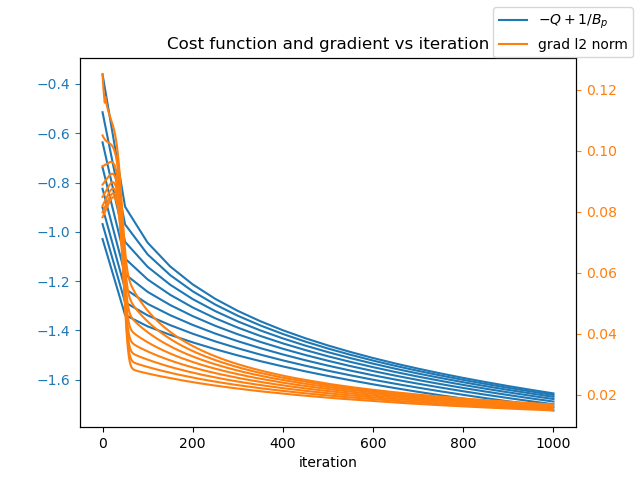

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [242]:
# print(jnp.array(simple_Q_opt.evaluate(0, 1001, 50))[:, 0])

fig, axQ = plt.subplots()
axQ.plot(np.arange(0, 1001, 50), jnp.array(simple_Q_opt.evaluate(0, 1001, 50))[:, 1:], color="#1f77b4")
axQ.plot(np.arange(0, 1001, 50), jnp.array(simple_Q_opt.evaluate(0, 1001, 50))[:, 0], label='$-Q + 1/B_p$', color="#1f77b4")
axQ.tick_params(colors="#1f77b4", axis='y')
axGrad = axQ.twinx()
axGrad.plot(np.arange(0, 1000), np.sqrt(np.sum((np.array(simple_Q_opt.loop_gradients) * simple_Q_opt.opt_idx_mask) ** 2, axis=1))[:, 1:],
            color='#ff7f0e')
axGrad.plot(np.arange(0, 1000), np.sqrt(np.sum((np.array(simple_Q_opt.loop_gradients) * simple_Q_opt.opt_idx_mask) ** 2, axis=1))[:, 0],
            color='#ff7f0e', label='grad l2 norm')
axGrad.tick_params(colors="#ff7f0e", axis='y')
axQ.set_xlabel('iteration')
fig.legend()
axQ.set_title('Cost function and gradient vs iteration')
# axGrad.legend()
# plt.savefig('simple_Q_cost.pdf')

In [222]:
idx_to_print = 0
print("symbol \t value_i \t value_f \t RMS grad")
for i in range(len(simple_Q_opt.symbol_list)):
    print(simple_Q_opt.symbol_list[i].name + ":\t {:.4e}".format(simple_Q_opt.loop_values[0][i, idx_to_print]) + ":\t {:.4e}".format(
        simple_Q_opt.loop_values[-1][i, idx_to_print]), "\t {:.4e}".format(np.sqrt(np.sum(np.array(simple_Q_opt.loop_gradients[0:-1]) ** 2, axis=0))[i, idx_to_print]))

symbol 	 value_i 	 value_f 	 RMS grad
T_frac:	 5.0000e-01:	 5.0000e-01 	 0.0000e+00
beta:	 8.0000e-01:	 8.0000e-01 	 0.0000e+00
L_p:	 1.0000e+01:	 1.0000e+01 	 0.0000e+00
Z_eff:	 1.1300e+00:	 1.1300e+00 	 0.0000e+00
Tep_fudge:	 5.0000e-01:	 5.0000e-01 	 0.0000e+00
p_aux:	 0.0000e+00:	 0.0000e+00 	 0.0000e+00
B_pm:	 7.0000e+00:	 3.5770e+01 	 1.0110e+00
mu:	 2.5000e+00:	 2.5000e+00 	 0.0000e+00
r_b:	 2.5000e-01:	 2.5000e-01 	 0.0000e+00
B_p:	 6.0000e+00:	 2.0059e+00 	 5.2533e-01
Eb:	 1.0000e+03:	 1.0000e+03 	 0.0000e+00


In [212]:
[sym.name for sym in simple_Q_opt.symbol_list].index('B_p')

9

In [209]:
simple_Q_opt.loop_values[6]

Array([[           nan, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01],
       [           nan, 8.00000000e-01, 8.00000000e-01, 8.00000000e-01,
        8.00000000e-01, 8.00000000e-01, 8.00000000e-01, 8.00000000e-01],
       [           nan, 4.00000000e+00, 4.00000000e+00, 4.00000000e+00,
        4.00000000e+00, 4.00000000e+00, 4.00000000e+00, 4.00000000e+00],
       [           nan, 1.13000000e+00, 1.13000000e+00, 1.13000000e+00,
        1.13000000e+00, 1.13000000e+00, 1.13000000e+00, 1.13000000e+00],
       [           nan, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [           nan, 8.47438177e+00, 1.03771299e+01, 1.23130772e+01,
        1.42674894e+01, 1.62332970e+01, 1.82066981e+01, 2.

<IPython.core.display.Javascript object>


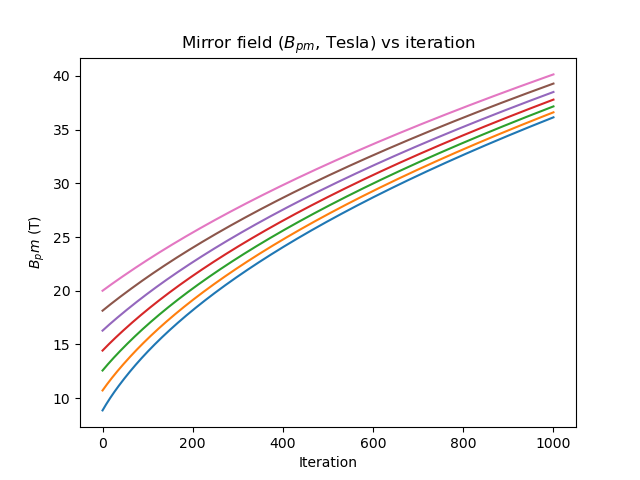

In [249]:
plt.figure()
plt.title("Mirror field ($B_{pm}$, Tesla) vs iteration")
plt.plot(np.array(simple_Q_opt.loop_values)[:, 6, 1:])
plt.ylabel("$B_pm$ (T)")
plt.xlabel('Iteration')
plt.savefig('mirror_field_iteration.pdf')

<IPython.core.display.Javascript object>


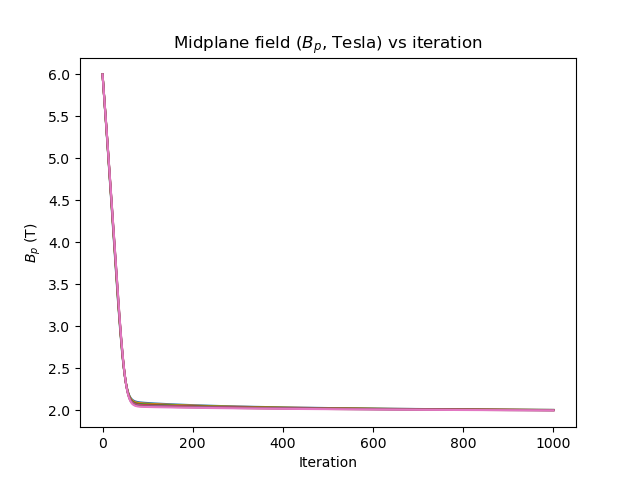

In [248]:
plt.figure()
plt.title("Midplane field ($B_p$, Tesla) vs iteration")
plt.plot(np.array(simple_Q_opt.loop_values)[:, 9, 1:])
plt.ylabel("$B_p$ (T)")
plt.xlabel('Iteration')
plt.savefig('midplane_field_iteration.pdf')

In [201]:
Q_optimized = simple_Q_opt.evaluate_sympy_func(Q_plug * 1.0, iter_start=0, iter_end=1000, iter_step=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


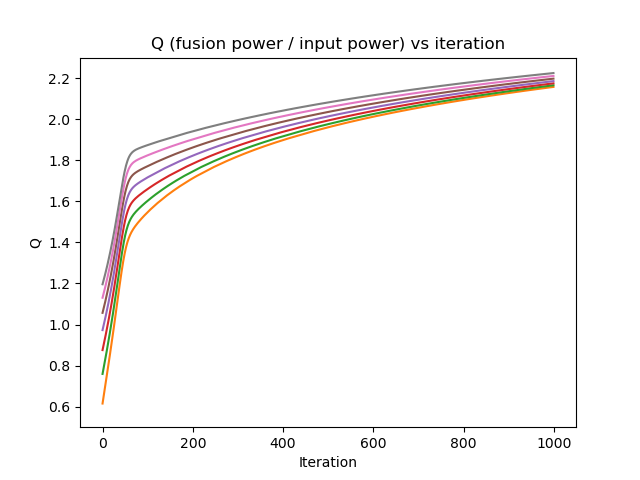

In [258]:
plt.figure()
# plt.plot(np.array(Q_optimized)[:, 0])
plt.plot(np.array(Q_optimized)[:])
plt.title('Q (fusion power / input power) vs iteration')
plt.xlabel('Iteration')
plt.ylabel('Q')
plt.ylim(0.5, 2.3)
plt.savefig('Q_vs_iteration.pdf')

In [ ]:
# simple_Q_opt.run(num_iterations=1000, step_size=1e-3)

# fig, axQ = plt.subplots()
# axQ.plot(np.arange(0, 2001, 50), jnp.array(simple_Q_opt.evaluate(0, 2001, 50))[:, 0:], label='$-Q + 1/B_p$', color="#1f77b4")
# axQ.tick_params(colors="#1f77b4", axis='y')
# axGrad = axQ.twinx()
# axGrad.plot(np.arange(0, 2000), np.sqrt(np.sum(np.array(simple_Q_opt.loop_gradients) ** 2, axis=1)),
#             color='#ff7f0e', label='grad l2 norm')
# axGrad.tick_params(colors="#ff7f0e", axis='y')
# axQ.set_xlabel('iteration')
# fig.legend()


# ## Plot Q and gradient norm
# fig, axQ = plt.subplots()
# axQ.plot(np.arange(0, 1001, 50), [cost_func_jax(*tuple(_[:, 0]))
#                                    for _ in tqdm(Q_values[::50])], label='Q', color="#1f77b4")
# axQ.tick_params(colors="#1f77b4", axis='y')
# # axQ.plot(Q_plug_function(*tuple([np.array(Q_values).transpose()[_, :] for _ in tqdm(range(8))])), label='Q')
# axGrad = axQ.twinx()
# axGrad.plot(np.sqrt(np.sum(np.array(loop_Q_grad) ** 2, axis=1))[:, 0],
#             color='#ff7f0e', label='grad l2 norm')
# # axGrad.plot(np.array(loop_Q_grad)[:, 0], color='#ff7f0e', label='grad l2 norm')
# axGrad.tick_params(colors="#ff7f0e", axis='y')
# axQ.set_xlabel('iteration')
# fig.legend()

# fig.savefig('Q_opt.pdf')


## Other plots
# Te_subbed, Te_jaxed, Te_arg_tuple, Te_arg_idx = sub_and_lambdify(
#     1.0 * Te, values, symbol_list_names)
# Ti_subbed, Ti_jaxed, Ti_arg_tuple, Ti_arg_idx = sub_and_lambdify(
#     1.0 * Ti, values, symbol_list_names)

# Te_jaxed = jax.vamp(Te_jaxed, jnp.arange(4))
# Ti_jaxed = jax.vamp(Ti_jaxed, jnp.arange(4))

# Te_plot = [Te_jaxed(*tuple(Q_values[i][Te_arg_idx])) for i in tqdm(range(0, 5001, 25))]
# Ti_plot = [Ti_jaxed(*tuple(Q_values[i][Ti_arg_idx])) for i in tqdm(range(0, 5001, 25))]

# figT, axTi = plt.subplots()

# axTi.plot(np.arange(0, 5001, 25), Ti_plot, color='blue', label='<Ei>')
# axTi.tick_params(colors='blue', axis='y')
# axTe = axTi.twinx()
# axTe.plot(np.arange(0, 5001, 25), Te_plot, color='red', label='Te')
# axTe.tick_params(colors='red', axis='y')
# axTi.set_xlabel('iteration')
# figT.legend()

# figT.savefig('temp_change.pdf')



















































